In [59]:
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
import re
import nltk

In [60]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [61]:
!pip install pymorphy2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [62]:
!pip install colorama

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [63]:
import pymorphy2
from colorama import Style, Fore

In [30]:
test_df = pd.read_csv("test_data.csv")

In [64]:
test_df.head()

,dlg_id,line_n,role,text
0,0,0,client,Алло
1,0,1,manager,Алло здравствуйте
2,0,2,client,Добрый день
3,0,3,manager,Меня зовут ангелина компания диджитал бизнес з...
4,0,4,client,Ага


In [65]:
print("Количество диалогов - {0}".format(test_df.dlg_id.value_counts().shape[0]))

Количество диалогов - 6


In [66]:
DLG_NUM = 6

In [67]:
gruped = test_df.groupby(['dlg_id', 'role']).agg('count').reset_index()

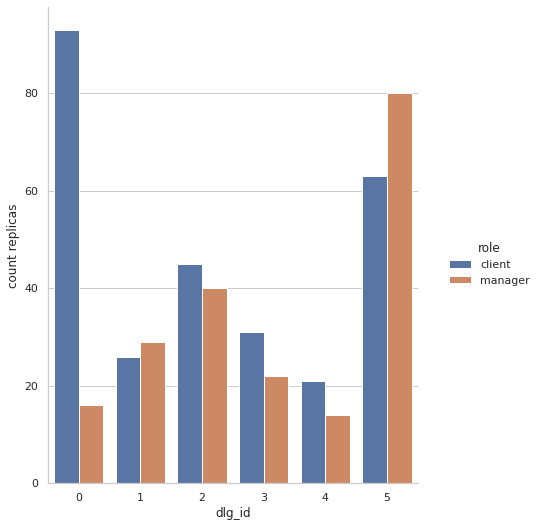

In [68]:
sns.set_theme(style="whitegrid")
ax = sns.catplot(data=gruped, kind='bar', 
                 x='dlg_id', y='line_n', 
                 hue='role')
ax.fig.set_size_inches(8,8)
ax.set_axis_labels("dlg_id", "count replicas")

In [69]:
class Dialogue:
    
    def __init__(self, dataframe, dlg_id):
        self.data = dataframe
        self.dlg_id = dlg_id
    
    def get_manager_replicas(self):
        manager_replicas = self.data[(self.data['dlg_id']==self.dlg_id) 
                                     & (self.data['role']=='manager')]
        return list(manager_replicas['text'].values)

В самом лучшем случае, всю необходимую информацию можно извлечь из двух реплик менеджера. 'a', 'b', 'c', 'd' можно извлечь из приветствия, например "Здравствуйте меня зовут", Имя, "компания (я из компании и т.д.)", Название_компании, ... 'e' извлекаем из последней реплики

# Приветствие (a)

Приветствие обычно располагается в начале диалога (в первых двух-трех сообщениях собеседника). Но могут быть "выбросы", связанные например с полхой связью: когда перед приветствием, менеджер уведомляет клиента о том, что его плохо слышно или наоборот. В таких ситуациях приветствие следует после 5-10 реплик каждого участника диалога.

In [70]:
def get_greeting(corpus):
    greetings = ['доброе утро', 'добрый день', 
                 'добрый вечер', 'здравствуйте', 
                 'приветствую', 'приветствует']
    for i, token in enumerate(corpus[:10]):
        for phrase in greetings:
            if phrase in token:
                return corpus[i]

In [71]:
for i in range(DLG_NUM):
    dialog = Dialogue(test_df, i)
    corpus = dialog.get_manager_replicas()
    print("Приветствие из {0}-го диалога: {1}".format(i, get_greeting(corpus)))

Приветствие из 0-го диалога: Алло здравствуйте
Приветствие из 1-го диалога: Алло здравствуйте
Приветствие из 2-го диалога: Алло здравствуйте
Приветствие из 3-го диалога: Алло дмитрий добрый день
Приветствие из 4-го диалога: None
Приветствие из 5-го диалога: None


# Представление, имя (b, c)

На примере четвертого диалога мы видим, что менеджеры могут знать имя клиента и обратится по нему в разговоре: "Алло, Дмитрий, добрый день". Поэтому искать первое попавшееся имя в репликах менеджера, и извлечь это имя в качестве его имени не лучшее решение. Следует искать паттерн: Имя, "меня", "зовут".

In [72]:
def first_letter_up(word):
    return word[0].upper()+word[1:]

def get_manager_name(corpus):
    morph = pymorphy2.MorphAnalyzer()
    patterns = ['меня', 'зовут', 'это']
    name = None
    identification = None
    for i, token in enumerate(corpus):
        for pattern in patterns:
            if pattern in token:
                for word in nltk.word_tokenize(token):
                    for p in morph.parse(word):
                        if 'Name' in p.tag and p.score > 0.5:
                            name = first_letter_up(word)
                            identification = corpus[i]
                            break
    return {'manager_name':name, 'identification':identification}

In [73]:
for i in range(DLG_NUM):
    dialog = Dialogue(test_df, i)
    corpus = dialog.get_manager_replicas()
    manager_name = get_manager_name(corpus)
    print("{0}-й диалог. \nИмя менеджера: {1}\nПредставление: {2}\n".format(i, 
                                                                            manager_name['manager_name'], 
                                                                            manager_name['identification']))

0-й диалог. 
Имя менеджера: Ангелина
Представление: Меня зовут ангелина компания диджитал бизнес звоним вам по поводу продления лицензии а мы с серым у вас скоро срок заканчивается

1-й диалог. 
Имя менеджера: Ангелина
Представление: Меня зовут ангелина компания диджитал бизнес звоню вам по поводу продления а мы сели обратила внимание что у вас срок заканчивается

2-й диалог. 
Имя менеджера: Ангелина
Представление: Меня зовут ангелина компания диджитал бизнес звоню вам по поводу продления лицензии а мастера мы с вами сотрудничали по видео там

3-й диалог. 
Имя менеджера: Максим
Представление: Добрый меня максим зовут компания китобизнес удобно говорить

4-й диалог. 
Имя менеджера: None
Представление: None

5-й диалог. 
Имя менеджера: Анастасия
Представление: Да это анастасия



На примере 5го диалога видим, что в общении с менеджером могут встречатся фразы "да это анастасия" и подобные ей "добрый день это анастасия" и т.п., смысловая нагрузка которых напрямую зависит от интонации. Если это утверждение - то скорее всего данной фразой менеджер представил себя, а если это вопрос, то скорее всего он риторический и менеджер таким образом начинает беседу с клиентом.

# Название компании (d)

Извлечь название компании - самя сложная задача, поскольку во-первых оно может быть англицизмом, что затрудняет морфологический разбор, во-вторых оно может состаять из нескольких слов, что делает неэфективным искать слово "компания" и извлекать следующее слово в качестве названия компании.

### Первый способ

Первый способ - искать слово "компания", добавлять первое слово после него в список и следующие существительные до тех пор пока не обноружится другая часть речи, поскольку названия компаний часто включают существительные. Из образовавшегося списка уже составлять название компании:

In [74]:
def find_word(normal_form, corpus):
    lemmatizer = pymorphy2.MorphAnalyzer()
    for i, token in enumerate(corpus[:12]):
        words = nltk.word_tokenize(token)
        for j, word in enumerate(words):
            if lemmatizer.parse(word)[0].normal_form == normal_form:
                return {'token_num':i, 'word_num':j}
    return None

In [75]:
def get_company_name(corpus):
    word_dict = find_word('компания', corpus)
    if not word_dict:
        return None
    token_num, word_num = word_dict['token_num'], word_dict['word_num']
    lemmatizer = pymorphy2.MorphAnalyzer()
    words = nltk.word_tokenize(corpus[token_num])

    company_name = []
    company_name.append(words[word_num+1])
    for i in range(word_num+2, len(words)):
        if not ('NOUN' in lemmatizer.parse(words[i])[0].tag):
            break
        company_name.append(words[i])
    return " ".join(company_name)

In [76]:
for i in range(DLG_NUM):
    dialog = Dialogue(test_df, i)
    corpus = dialog.get_manager_replicas()
    print("Название компании из {0}-го диалога: {1}".format(i, get_company_name(corpus)))

Название компании из 0-го диалога: диджитал бизнес
Название компании из 1-го диалога: диджитал бизнес
Название компании из 2-го диалога: диджитал бизнес
Название компании из 3-го диалога: китобизнес
Название компании из 4-го диалога: None
Название компании из 5-го диалога: None


Видно, что такой подход на тестовых данных хорошо показывает себя 

### Второй способ

Второй способ - востановить пункуацию в репликах, разбивать предложение по знакам препинания и так же искать слово "компания". Востанавливать пунктуацию можно с помощью моделей silero: https://github.com/snakers4/silero-models

In [77]:
from torch import package

In [78]:
imp = package.PackageImporter('v2_4lang_q.pt')
model = imp.load_pickle("te_model", "model")

def apply_te(text, lan='ru'):
    return model.enhance_text(text, lan)

In [79]:
for i in range(DLG_NUM):
    dialog = Dialogue(test_df, i)
    corpus = dialog.get_manager_replicas()
    word_dict = find_word('компания', corpus)
    if not word_dict:
        print("В {0}-м диалоге не найдено слово `компания`\n".format(i))
    else:
        token_num, word_num = word_dict['token_num'], word_dict['word_num']
        text_whith_punct = apply_te(corpus[token_num].lower())
        print("Реплика из {0}-го диалога с востановленной пунктуацией:\n {1}\n".format(i, text_whith_punct))

Реплика из 0-го диалога с востановленной пунктуацией:
 Меня зовут Ангелина, компания диджитал бизнес, звоним вам по поводу продления лицензии, а мы с серым у вас скоро срок заканчивается.

Реплика из 1-го диалога с востановленной пунктуацией:
 Меня зовут Ангелина, компания диджитал бизнес звоню вам по поводу продления, а мы сели обратила внимание, что у вас срок заканчивается.

Реплика из 2-го диалога с востановленной пунктуацией:
 Меня зовут Ангелина, компания диджитал бизнес звоню вам по поводу продления лицензии, а мастера мы с вами сотрудничали по видео там.

Реплика из 3-го диалога с востановленной пунктуацией:
 Добрый меня Максим зовут компания Китобизнес удобно говорить.

В 4-м диалоге не найдено слово `компания`

В 5-м диалоге не найдено слово `компания`



Видно, что данная модель плохо востанавливает пунктуацию в репликах. Это связанно с тем, что текст генерировался с помошью STT-моделей, которые на данный момент не обладают безупречной точностью. Так же это связано с тем, что в обучающей выборке используемой модели, было очень мало текстов-диалогов; она состояла в основном из статей, литературы, новостей и т.д.
Модели, "заточенные" под диалоги, используются редко, в узком поле задач, и найти готовые, доступные рускоязычные решения врядли возможно.

### Третий способ

Третий способ - спарсить синтаксические зависимости, и проанализировать полученное дерево с целью выявить отношения словом "компания" и названием

In [80]:
import spacy
from spacy import displacy

In [81]:
!python -m spacy download ru_core_news_sm

2022-09-03 14:21:57.545192: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 15.3 MB 4.1 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_sm')


In [82]:
nlp = spacy.load('ru_core_news_sm')

In [83]:
for i in range(DLG_NUM):
    dialog = Dialogue(test_df, i)
    corpus = dialog.get_manager_replicas()
    word_dict = find_word('компания', corpus)
    if not word_dict:
        print("В {0}-м диалоге не найдено слово `компания`\n".format(i))
    else:
        token_num, word_num = word_dict['token_num'], word_dict['word_num']
        doc = nlp(corpus[token_num].lower())
        print(Style.BRIGHT+"Дерево для {0}-го диалога:".format(i))
        displacy.render(doc, style="dep", jupyter=True)

Дерево для 0-го диалога:


Дерево для 1-го диалога:


Дерево для 2-го диалога:


Дерево для 3-го диалога:


В 4-м диалоге не найдено слово `компания`

В 5-м диалоге не найдено слово `компания`



# Прощание (e)

In [84]:
def get_farewell(corpus):
    farewells = ['до свидания', 'всего доброго', 'всего хорошего', 'до связи']
    
    for phrase in farewells:
        if phrase in corpus[-1].lower():
            return corpus[-1]
    
    for i, token in enumerate(corpus):
        for phrase in farewells:
            if phrase in token.lower():
                return corpus[i]

In [85]:
for i in range(DLG_NUM):
    dialog = Dialogue(test_df, i)
    corpus = dialog.get_manager_replicas()
    print("Прощание из {0}-го диалога: {1}".format(i, get_farewell(corpus)))

Прощание из 0-го диалога: Всего хорошего до свидания
Прощание из 1-го диалога: До свидания
Прощание из 2-го диалога: None
Прощание из 3-го диалога: Угу все хорошо да понедельника тогда всего доброго
Прощание из 4-го диалога: Во вторник все ну с вами да тогда до вторника до свидания
Прощание из 5-го диалога: Ну до свидания хорошего вечера
